In [114]:
import scipy as sp
import pylab as plt
from scipy.integrate import odeint
import numpy as np
from numpy import linalg
import random
from ndtools import clines
%matplotlib inline  

In [85]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

In [3]:
# set constants
C_m = 1 # uF/cm2

E_Ca = 100 # mV
E_K = - 70 # mV
E_L = -50  # mV

g_Ca = 1.1 # mS/cm2
g_K = 2.0  # mS/cm2
g_L = 0.5  # mS/cm2

In [107]:
def I_Ca(V):
    return g_Ca*m_inf(V)*(V-E_Ca)
def I_K(V,w):
    return g_K*w*(V-E_K) # need to figure out w
def I_L(V):
    return g_L*(V-E_L)

def m_inf(V):
    return (1+np.tanh((V+1)/15))/2
def w_inf(V):
    return (1+np.tanh(V/30))/2
def T_w(V):
    return 5/ np.cosh(V/60) # ms

def dwdt(V,w):
    return(w_inf(V)-w)/T_w(V)

def dVdt(V,w,I_ext):
    return 1/C_m*(-I_Ca(V)-I_K(V,w)-I_L(V)+I_ext)

v_scale = np.arange(-60,60,1)
w_scale = np.arange(-.2,1.2,.01)
print(len(v_scale),len(w_scale))
[V,W] = np.meshgrid(v_scale,w_scale)

120 140


In [139]:
def NC(I_ext):
    return clines.getNullcline(dVdt(V,W,I_ext),v_scale,w_scale)
X_null_V_5, Y_null_V_5 = NC(5)
X_null_V_24, Y_null_V_24 = NC(24.3)
X_null_V_30, Y_null_V_30 = NC(30)

/Users/sheehantc/miniconda3/envs/py_run/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


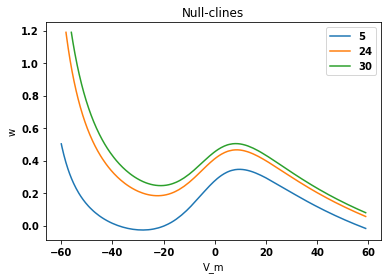

In [140]:
plt.plot(X_null_V_5,Y_null_V_5,label = '5')
plt.plot(X_null_V_24,Y_null_V_24,label = '24')
plt.plot(X_null_V_30,Y_null_V_30,label = '30')
plt.xlabel('V_m')
plt.ylabel('w')
plt.title('Null-clines')
plt.legend()

In [148]:
X_null_w, Y_null_w = clines.getNullcline(dwdt(V,W),v_scale,w_scale)

def int_NC(I_ext):
    X_null_V_I, Y_null_V_I = NC(I_ext)
    return clines.getCrossings(X_null_V_I,Y_null_V_I,X_null_w,Y_null_w)

def eig_NC(I_ext):
    X_null_V_I, Y_null_V_I = NC(I_ext)
    x_int, y_int = int_NC(I_ext)
    J = clines.getJacobian(V,W,dVdt(V,W,I_ext),dwdt(V,W),x_int,y_int)
    J = np.squeeze(J)
    VI,DI = linalg.eig(J)
    return np.real(VI)
    

In [153]:
# If real part of all eigenvalues are negative, then ODE is stable at 
# need to repeat all above for other currents as well
print('EIG I_ext = 5: ', eig_NC(5))
print('EIG I_ext = 24.3: ',eig_NC(24.3))
print('EIG I_ext = 30: ',eig_NC(30))

EIG I_ext = 5:  [-0.396717 -0.396717]
EIG I_ext = 24.3:  [-0.09166926 -0.09166926]
EIG I_ext = 30:  [ 0.27011238  0.27011238]


In [170]:
def small_pert(var,is_x,amnt=2):
    if is_x:
        return np.array((var +amnt, var+amnt, var-amnt,var-amnt))
    else:
        return np.array((var +amnt, var-amnt, var-amnt,var+amnt))


In [171]:
x_int, y_int = int_NC(5)
x_pert_I = small_pert(x_int,True,2)
y_pert_I = small_pert(y_int,False,2)


In [201]:
#1.c
st_pts = np.hstack((x_pert_I,y_pert_I))
print(st_pts)
t = np.arange(0,.001,100)
I_ext = 5
for i in range(len(x_pert_I)):
    def dXdtI(t,XI):
        return dVdt(XI[:],I_ext),dwdt(XI[:])
    y0 = np.concatenate((x_pert_I[i],y_pert_I[i]))
    out = odeint(dXdtI,y0,t)
    print(out)

[[-42.16598204   2.0500104 ]
 [-42.16598204  -1.9499896 ]
 [-46.16598204  -1.9499896 ]
 [-46.16598204   2.0500104 ]]
[[-42.16598204   2.0500104 ]]
[[-42.16598204  -1.9499896 ]]
[[-46.16598204  -1.9499896 ]]
[[-46.16598204   2.0500104 ]]


In [202]:
#d
print('EIG I_ext = 220: ',eig_NC(220))

EIG I_ext = 220:  [-3.46224907 -0.3174134 ]


In [ ]:
#2
